Shape: (383, 17)

Columns and dtypes:
 Age                      int64
Gender                  object
Smoking                 object
Hx Smoking              object
Hx Radiothreapy         object
Thyroid Function        object
Physical Examination    object
Adenopathy              object
Pathology               object
Focality                object
Risk                    object
T                       object
N                       object
M                       object
Stage                   object
Response                object
Recurred                object
dtype: object

Missing values:
 Age                     0
Gender                  0
Smoking                 0
Hx Smoking              0
Hx Radiothreapy         0
Thyroid Function        0
Physical Examination    0
Adenopathy              0
Pathology               0
Focality                0
Risk                    0
T                       0
N                       0
M                       0
Stage                   0
Response    

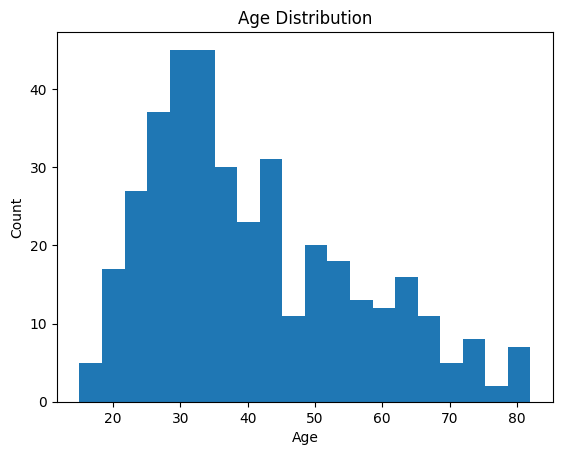

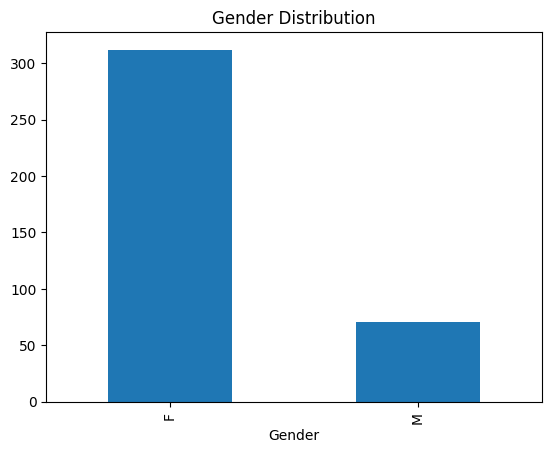

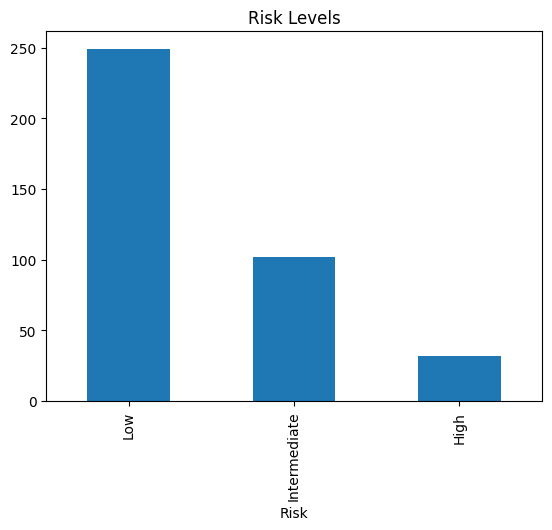

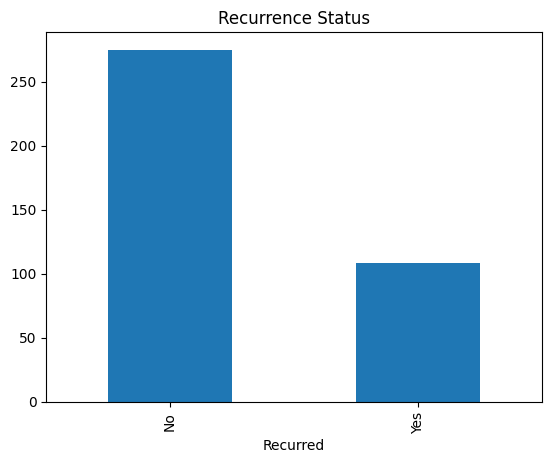

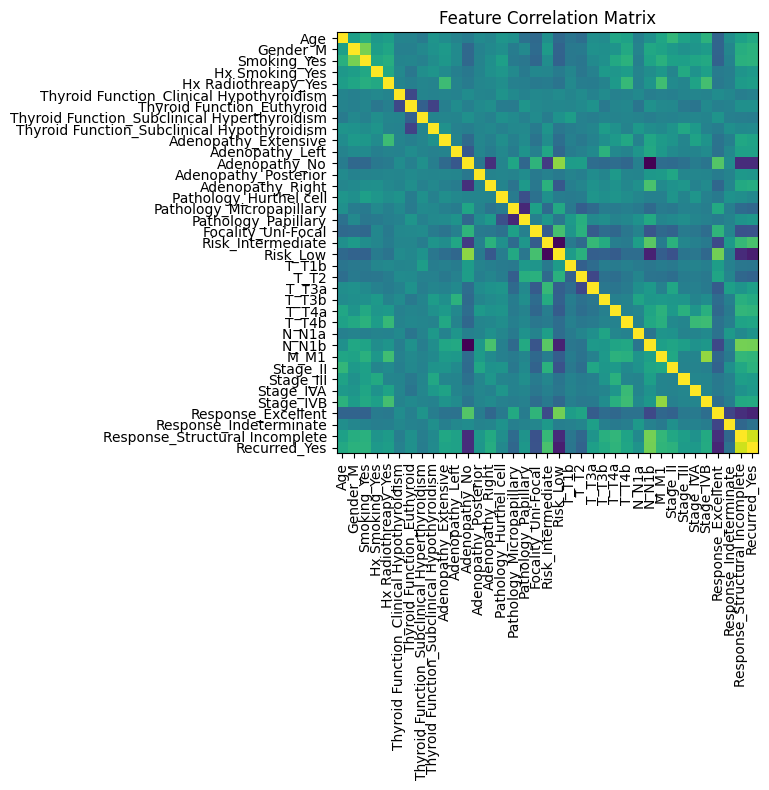

Train balance before: {False: 0.7189542483660131, True: 0.28104575163398693}
Train balance after : {False: 0.5, True: 0.5}
Best LR params: {'C': 10, 'penalty': 'l2'}
Best RF params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}

Logistic Regression Confusion Matrix:
[[53  2]
 [ 2 20]]

Random Forest Confusion Matrix:
[[55  0]
 [ 2 20]]

Performance Summary:
                      Precision    Recall  F1-Score   ROC AUC
Logistic Regression   0.909091  0.909091  0.909091  0.977686
Random Forest         1.000000  0.909091  0.952381  0.987190

Performance Summary:
                      Precision    Recall  F1-Score   ROC AUC
Logistic Regression   0.909091  0.909091  0.909091  0.977686
Random Forest         1.000000  0.909091  0.952381  0.987190


In [2]:
# =============================================================================
# Differentiated Thyroid Cancer Recurrence Prediction Notebook Script
# =============================================================================

# 0. IMPORT LIBRARIES
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# 1. LOAD DATA
df = pd.read_csv("thyroid_cancer.csv")

# 2. DATA INSPECTION
print("Shape:", df.shape)
print("\nColumns and dtypes:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())
print("\nTarget distribution:\n", df["Recurred"].value_counts())

# 3. EDA VISUALIZATIONS
plt.figure(); plt.hist(df["Age"], bins=20); plt.title("Age Distribution"); plt.xlabel("Age"); plt.ylabel("Count"); plt.show()
plt.figure(); df["Gender"].value_counts().plot(kind="bar"); plt.title("Gender Distribution"); plt.show()
plt.figure(); df["Risk"].value_counts().plot(kind="bar"); plt.title("Risk Levels"); plt.show()
plt.figure(); df["Recurred"].value_counts().plot(kind="bar"); plt.title("Recurrence Status"); plt.show()

# Correlation heatmap (after encoding)
df_enc = pd.get_dummies(df.drop(columns=["Physical Examination"]), drop_first=True)
corr = df_enc.corr()
plt.figure(figsize=(10,8)); plt.imshow(corr); plt.title("Feature Correlation Matrix")
plt.xticks(range(len(corr)), corr.columns, rotation=90); plt.yticks(range(len(corr)), corr.columns); plt.tight_layout(); plt.show()

# 4. PREPROCESSING
df_enc = pd.get_dummies(df, drop_first=True)
X = df_enc.drop(columns=["Recurred_Yes"])
y = df_enc["Recurred_Yes"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train["Age"] = scaler.fit_transform(X_train[["Age"]])
X_test["Age"] = scaler.transform(X_test[["Age"]])

train_df = pd.concat([X_train, y_train], axis=1)
majority = train_df[train_df["Recurred_Yes"] == 0]
minority = train_df[train_df["Recurred_Yes"] == 1]
minority_up = resample(minority, replace=True, n_samples=len(majority), random_state=42)
train_up = pd.concat([majority, minority_up])
X_train_up = train_up.drop(columns=["Recurred_Yes"])
y_train_up = train_up["Recurred_Yes"]

print("Train balance before:", y_train.value_counts(normalize=True).to_dict())
print("Train balance after :", y_train_up.value_counts(normalize=True).to_dict())

# 5. MODELING & TUNING
lr = LogisticRegression(solver="liblinear", max_iter=1000)
lr_params = {"C": [0.01, 0.1, 1, 10], "penalty": ["l1", "l2"]}
lr_grid = GridSearchCV(lr, lr_params, cv=5, scoring="roc_auc")
lr_grid.fit(X_train_up, y_train_up)
best_lr = lr_grid.best_estimator_
print("Best LR params:", lr_grid.best_params_)

rf = RandomForestClassifier(random_state=42)
rf_params = {"n_estimators": [50, 100, 200], "max_depth": [None, 5, 10], "min_samples_split": [2, 5]}
rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring="roc_auc")
rf_grid.fit(X_train_up, y_train_up)
best_rf = rf_grid.best_estimator_
print("Best RF params:", rf_grid.best_params_)


# 6. EVALUATION (robust metric extraction)
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

models = {"Logistic Regression": best_lr, "Random Forest": best_rf}
results = {}
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Compute metrics directly
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall    = recall_score(y_test, y_pred, pos_label=1)
    f1        = f1_score(y_test, y_pred, pos_label=1)
    roc_auc   = roc_auc_score(y_test, y_prob)
    cm        = confusion_matrix(y_test, y_pred)

    results[name] = {
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "ROC AUC": roc_auc
    }
    print(f"\n{name} Confusion Matrix:\n{cm}")

# Display as DataFrame
res_df = pd.DataFrame(results).T
print("\nPerformance Summary:\n", res_df)


res_df = pd.DataFrame(results).T
print("\nPerformance Summary:\n", res_df)
